In [3]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import math

import pandas as pd

import scipy.integrate as integrate
import scipy.special as sp
import scipy.optimize as spop
import scipy.ndimage.filters as filters

import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})

## Generative model

The model is represented by a 2D Gaussian, with random peak amplitude, width and position.

We thus start by defining the 2D Gaussian function:

In [4]:
def gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y):
    return amplitude*np.exp(-(x-center_x)**2/(2*sigma_x**2))*np.exp(-(y-center_y)**2/(2*sigma_y**2))    

The background is defined as an overall offset, and scattered light added on. This is modeled as a poissonian since it is shot noise limited.

In [5]:
def background(image_size,offset,scattered_light):
    N=image_size
    return np.add([[scattered_light for i in range(N)] for j in range(N)],offset)

We next define the model for the MOT:

In [6]:
def MOTmodel(x, y, center_x, center_y, amplitude, sigma_x, sigma_y):
    return gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y)

Now the image which is captured by the camera, due to the low number of photons collected, is a poissonian distribution, centered around the model

In [7]:
def detected(model):
    return np.random.poisson(model)

The image size in pixels is set here

In [8]:
image_size=50
x=np.linspace(1,image_size,image_size)
y=np.linspace(1,image_size,image_size)
x,y=np.meshgrid(x, y)

For a single image, we would find something like this

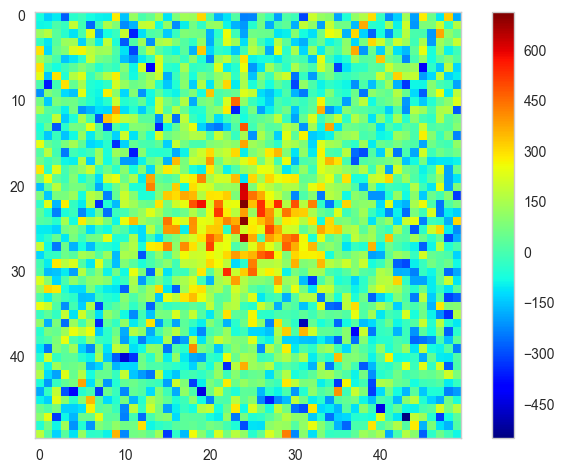

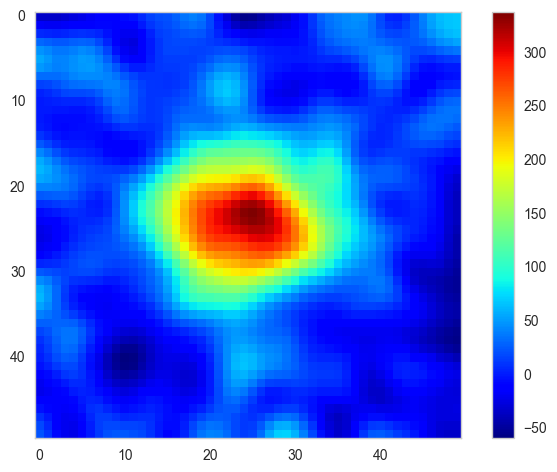

In [18]:
image=detected(MOTmodel(x,y,image_size/2,image_size/2,400,image_size/7.5,image_size/9))+detected(background(image_size,0,10000))-detected(background(image_size,0,10000))

plt.figure(1)
plt.imshow(image,cmap="jet", interpolation='none')
plt.colorbar()


plt.figure(2)
plt.imshow(filters.gaussian_filter(image,2),cmap="jet", interpolation='none' )
plt.colorbar()


Lastly we add CCD readout charge which is accumulated as a sum vertically

In [40]:
def Image_with_CCD_readout_charge(image,readout_charge):
    charge=(np.cumsum(image[::-1],axis=0)/readout_charge)
    return image+charge[::-1]

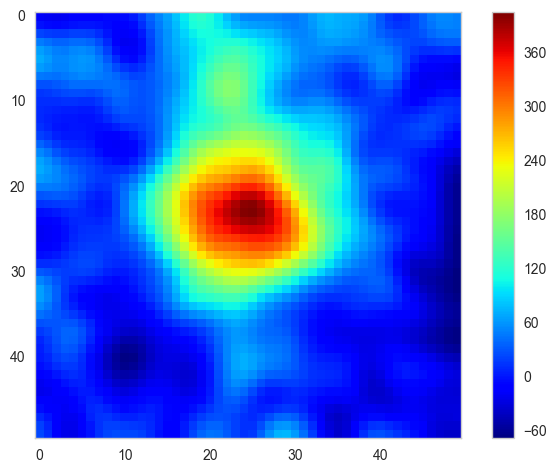

In [44]:
plt.figure(2)
plt.imshow(filters.gaussian_filter(Image_with_CCD_readout_charge(image,50),2),cmap="jet", interpolation='none' )
plt.colorbar()
